This notebook is used to plot disk metrics against the date-hour.
It depends on ``hourly_agg_util.py``. Therefore, the path to ``hourly_agg_util.py`` should be added to PYTHONPATH on the system where this notebook is used and ``hourly_agg_util.py`` should be passed to pyspark using the ``--py-files`` switch.

#### Using the notebook

The main function is ``call()``. This function should be called with following arguments
- The filename for hourly aggregated disk entries(metric 13183) on HDFS
- The name of the entity
- disks=A list of disk names which are to be plotted. This can be omitted or set to None to plot all disks
- what=A string denoting what is to be ploted. Valid values are
    - "rate" - Plot the rate in KB/s for read and write
    - "oprate" - Plot the number of ops per sec for read and write

In [1]:
import datetime
import itertools
from pprint import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import min as pymin
from pyspark.sql.functions import max as pymax

import hourly_agg_util as util

In [2]:
%matplotlib inline

In [3]:
def get_min_max(df):
    """
    Get minimum and maximum timestamp for data
    """
    min_max = df.select(pymin("group_interval_tstamp").alias("min_tstamp"), pymax("group_interval_tstamp").alias("max_tstamp")).collect()
    min_tstamp = min_max[0].min_tstamp
    max_tstamp = min_max[0].max_tstamp
    num_hours = (max_tstamp - min_tstamp)/3600
    return min_tstamp, max_tstamp, num_hours


def get_plot_data(df, entity, min_tstamp):
    """
    Returns the data in form of dict of dict:
        {
          DNAME: {
                   HOUR_INDEX: (ReadRate, ReadOpRate, WriteRate, WriteOpRate),
                 }
        }
    Where DNAME is the diskname (e.g. "vda", "vdb" etc.
    and HOUR_INDEX goes from 0 and denotes the hour number as counted from minimum recorded tstamp)
    """
    # find data for entity we are interested in
    # In this case it is possible that the "raw" and "hour" entries have different  HGs. So both will
    # occur in this hour, which may lead to inconsistencies in the plot
    # Therefore, we explicitly order by HG too so that result is deterministic in the plot
    df2 = df.filter("entity='{0}'".format(entity)).select(
        "submitter_hostgroup", "group_interval", "group_interval_tstamp", "avg_DiskReadRate", "avg_DiskWriteRate",
        "avg_DiskReadOpRate", "avg_DiskWriteOpRate", "DiskName").orderBy(
            ["DiskName", "group_interval_tstamp", "submitter_hostgroup"])
    rs = df2.collect()
    # Arrange the result as a dict of dicts
    res = {}
    for key, g in itertools.groupby(rs, key=lambda x: x.DiskName):
        g = list(g)
        tlist = [((x.group_interval_tstamp - min_tstamp) / 3600, (x.avg_DiskReadRate, x.avg_DiskReadOpRate,
                                                                  x.avg_DiskWriteRate, x.avg_DiskWriteOpRate)) for x in g]
        res[key] = dict(tlist)
    return res


def convert_timestamp_to_date_hr(ts):
    """
    Converts the given timestamp into string DD-MM-YYYY HH
    :param ts: The timestamp in SECONDS
    """
    return datetime.datetime(*time.gmtime(int(ts))[:6]).strftime("%d-%m-%Y %H")


def plottable_data(data, num_hours, min_tstamp, disks=None):
    """
    Convert the output data into plottable form.
    :param data: A dict of dict. The outer dict has disk name as key.
                 The inner dict has hour num (with 0 for first hour in data) as key
                 and (read, write, readop, writeop) as value
    :param num_hours: The number of hours in the entire data
    :param min_tstamp: The minimum time stamp (marking the beginning of data)
    :param disks: A list of disknames to plot. Default None, which means all
                  disks will be plotted
    Returns a dict of dict. The outer dict has disk name as key, while
    inner dict has 4 keys
    "readr": List denoting read rate values (includes nan)
    "writer": List denoting write rate values (includes nan)
    "readopr": List denoting read ops rate values (includes nan)
    "writeopr": List denoting write ops rate values (includes nan)
    """
    all_disk_names = sorted(data.keys())
    if disks is not None:
        disk_names = [x for x in all_disk_names if x in disks]
    else:
        disk_names = all_disk_names
    # Prepare the data into lists per disk name
    clean_data = {}
    for d in disk_names:
        clean_data[d] = {"readr": [],
                         "readopr": [],
                         "writer": [],
                         "writeopr": []}
        for h in xrange(0, num_hours + 1):
            vals = data[d].get(h, (np.nan, np.nan, np.nan, np.nan))
            clean_data[d]["readr"].append(vals[0])
            clean_data[d]["readopr"].append(vals[1])
            clean_data[d]["writer"].append(vals[2])
            clean_data[d]["writeopr"].append(vals[3])
    return clean_data
            
            
def _plotme(data, num_hours, min_tstamp, what="rate"):
    """
    :param what: Either "rate" or "oprate"
    """
    if what not in ("rate", "oprate"):
        what = "oprate"
    if what == "rate":
        keys = ("readr", "writer")
        title = "Disk Rates KB/s"
    else:
        keys = ("readopr", "writeopr")
        title = "Op Count /s"
    disk_names = sorted(data.keys())
    fig = plt.figure(figsize=(16, 12))
    fig.subplots_adjust(bottom=0.1)
    xaxis = np.arange(num_hours+1)
    
    # Add first plot
    ax0 = fig.add_subplot(211)
    ax0.set_title(title)

    legends = []
    for d in disk_names:
        # This is a dummy plot to get the color into legend
        l1, = plt.plot([0], marker='None', linestyle='-', linewidth=2)
        legends.append(l1)
        ax0.plot(xaxis, data[d][keys[0]], linestyle="--", color=l1.get_color())
        ax0.plot(xaxis, data[d][keys[1]], linestyle=":", color=l1.get_color())
            
    ax0.axis([0, num_hours+1, 0.0, 100.0])
    ax0.autoscale(enable=True, axis='y')
    
    a = ax0.get_xticks().tolist()
    ax0.set_xticklabels([convert_timestamp_to_date_hr(min_tstamp + int(m)*3600) for m in a], rotation="vertical")
     
    ax0.get_xaxis().set_tick_params(direction='out', width=1)
    ax0.get_yaxis().set_tick_params(direction='out', width=1)
    
    # Now we also need to plot the legend for read and write so we use dummies again
    l2, = plt.plot([0], color='k', marker='None', linestyle='--', linewidth=2)
    l3, = plt.plot([0], color='k', marker='None', linestyle=':', linewidth=2)
    legends2 = plt.legend([l2, l3], ["Read", "Write"], title="Operation Type", bbox_to_anchor=(1.15, 0.5))
    ax0.add_artist(legends2)
    ax0.legend(legends, disk_names, title="Disks", bbox_to_anchor=(1.15, 1.0))
    plt.show()

    
def plot_disk(data, num_hours, min_tstamp, disks=None, what="rate"):
    """
    Plot the graph for all the disks
    :param data: A dict of dict. The outer dict has disk name as key.
                 The inner dict has hour num (with 0 for first hour in data) as key
                 and (read, write, readop, writeop) as value
    :param num_hours: The number of hours in the entire data
    :param min_tstamp: The minimum time stamp (marking the beginning of data)
    :param disks: A list of disknames to plot. Default None, which means all
                  disks will be plotted
    :param what: String. One out of "rate" (for the dis rate in KB/s) and "oprate"
                 (for rate in number of ops/s). Default "rate"
    """
    if what not in ("rate", "oprate"):
        what = "oprate"
    mod_data = plottable_data(data, num_hours, min_tstamp, disks=disks)
    _plotme(mod_data, num_hours, min_tstamp, what=what)

In [4]:
def call(filename, entity, disks=None, what="rate"):
    df = sqlContext.read.json(filename)
    df = util.clean_data_for_hour(df, 4, extra_grouping_attr=["DiskName"])
    df = util.augment_group_interval(df)
    do(df, entity, disks=disks, what=what)


def do(df, entity, disks=None, what="rate"):
    min_tstamp, max_tstamp, num_hours = get_min_max(df)
    res = get_plot_data(df, entity, min_tstamp)
    plot_disk(res, num_hours, min_tstamp, disks=disks, what=what)

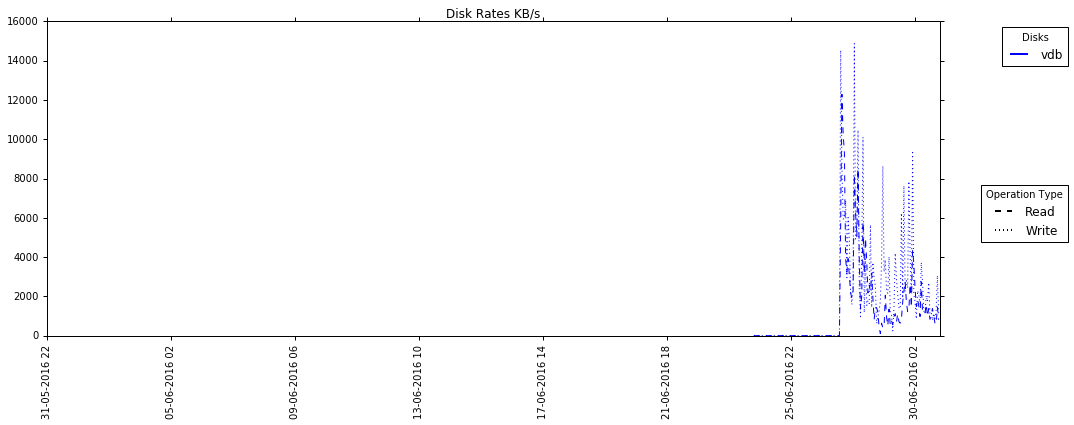

In [5]:
call("lemon_aggregates/bi/2016_06/hourly_13183", "b6cb338269", disks=["vdb"], what="rate")

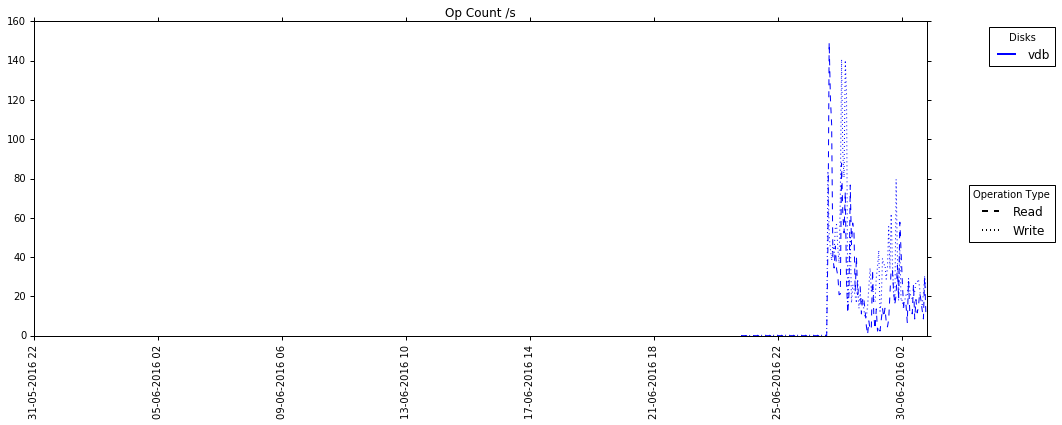

In [9]:
call("lemon_aggregates/bi/2016_06/hourly_13183", "b6cb338269", disks=["vdb"], what="oprate")

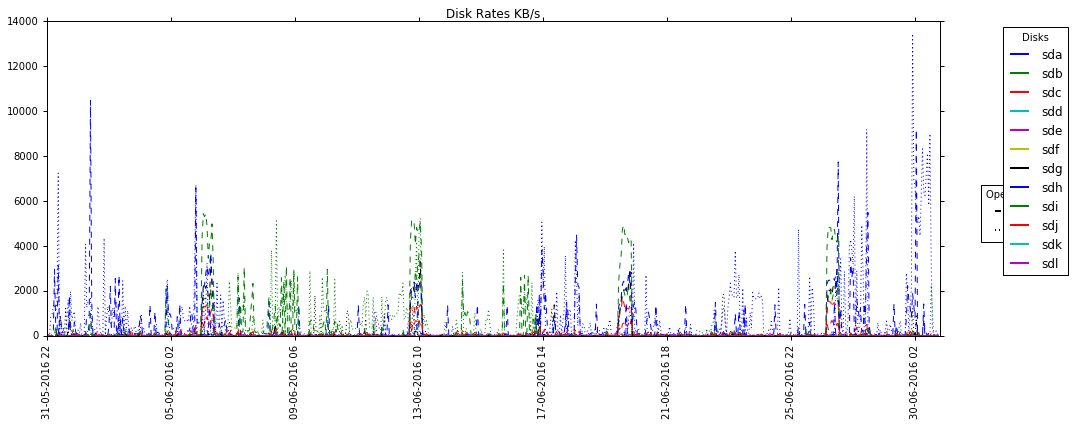

In [22]:
call("lemon_aggregates/bi/2016_06/hourly_13183", 'lxfssm4008', what="rate")
# This call demonstrates the weakness of using a fixed color cycle.
# Here there are 12 disks while our cycle has 7 colors.
# It may be advisable to use a colormap and get individual color from that
# For this see answer http://stackoverflow.com/a/16006929/533524 (Last point)

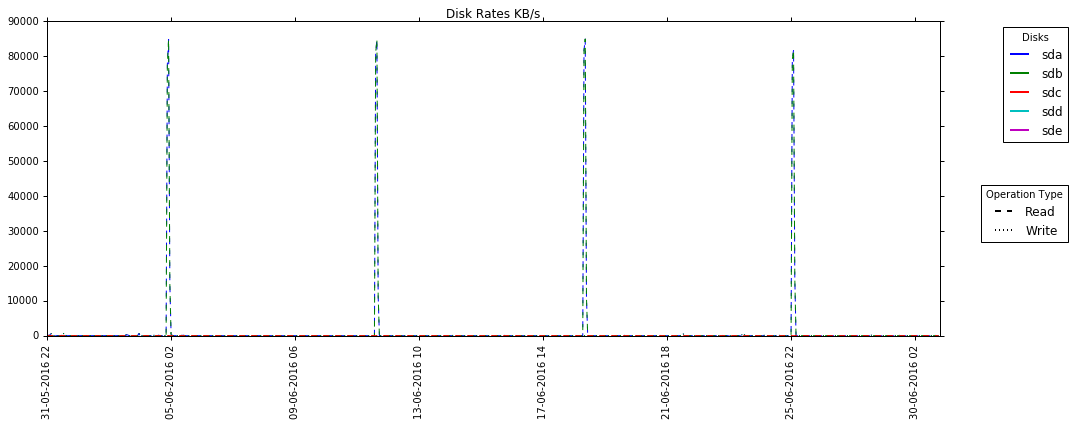

In [29]:
call("lemon_aggregates/bi/2016_06/hourly_13183", 'lxbrf49c07', what="rate")

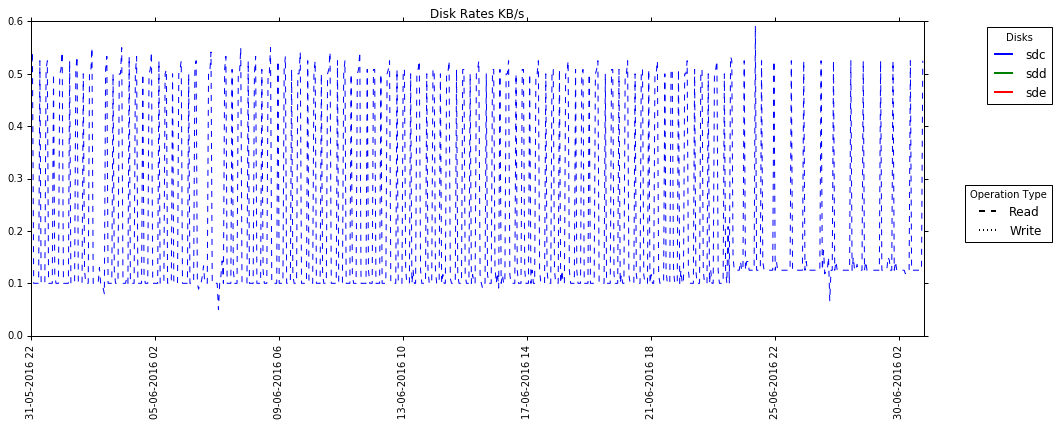

In [8]:
call("lemon_aggregates/bi/2016_06/hourly_13183", 'lxbrf49c07', disks=["sdc", "sdd", "sde"], what="rate")